In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms as T
from torchvision.utils import make_grid
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------
# DEVICE
# -------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cuda


## Load Dataset

In [2]:
# DATASET
# -------------------------------
class MyDataset(Dataset):
    def __init__(self, folder, image_size=64):
        exts = ["*.jpg","*.jpeg","*.png","*.bmp"]
        paths = []
        for e in exts:
            paths += list(Path(folder).glob(f"**/{e}"))

        if len(paths)==0:
            raise ValueError("No images found.")

        # Using full dataset
        keep = int(len(paths))
        self.paths = paths[:keep]

        self.transform = T.Compose([
            T.Resize((image_size,image_size)),
            T.ToTensor(),
            T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
        ])

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = Image.open(self.paths[idx]).convert("RGB")
        return self.transform(img)

dataset = MyDataset("/kaggle/input/bitmojis/bitmojis",64)
loader = DataLoader(dataset,batch_size=32,shuffle=True)

In [3]:
# DDPM SCHEDULE
# -------------------------------
def linear_beta_schedule(T):
    return torch.linspace(1e-4, 0.02, T)

T_STEPS = 200

betas = linear_beta_schedule(T_STEPS).to(device)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)

sqrt_ac = torch.sqrt(alphas_cumprod)
sqrt_om = torch.sqrt(1 - alphas_cumprod)

In [4]:
# FORWARD DIFFUSION (q_sample)
# -------------------------------
def q_sample(x0, t):
    noise = torch.randn_like(x0)
    return (
        sqrt_ac[t].view(-1,1,1,1)*x0 +
        sqrt_om[t].view(-1,1,1,1)*noise,
        noise
    )

In [5]:
# POSITIONAL TIME EMBEDDING
# -------------------------------
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.linear1 = nn.Linear(1, dim)
        self.linear2 = nn.Linear(dim, dim)

    def forward(self, t):
        t = t.float().unsqueeze(1)
        x = F.relu(self.linear1(t))
        return self.linear2(x).view(-1, x.size(-1), 1, 1)

In [6]:
# STRICT SIZE-PRESERVING U-NET
# -------------------------------
class SimpleUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.down1 = nn.Conv2d(3,32,3,padding=1)
        self.down2 = nn.Conv2d(32,64,3,padding=1)

        self.time_emb = TimeEmbedding(64)

        self.mid = nn.Conv2d(64,64,3,padding=1)

        self.up1 = nn.Conv2d(64,32,3,padding=1)
        self.out = nn.Conv2d(32,3,3,padding=1)

    def forward(self,x,t):
        t_emb = self.time_emb(t)

        x1 = F.relu(self.down1(x))
        x2 = F.relu(self.down2(x1))

        mid = F.relu(self.mid(x2 + t_emb))

        up = F.relu(self.up1(mid))

        return self.out(up)

model = SimpleUNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [7]:
# TRAINING STEP
# -------------------------------
def train_step(x0):
    x0 = x0.to(device)
    b = x0.size(0)
    t = torch.randint(0, T_STEPS, (b,), device=device)

    x_t, noise = q_sample(x0, t)
    noise_pred = model(x_t, t)

    loss = F.mse_loss(noise_pred, noise)
    return loss

In [8]:
# TRAIN LOOP
# -------------------------------
EPOCHS = 30
for epoch in range(EPOCHS):
    for batch in loader:
        loss = train_step(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{EPOCHS}  Loss = {loss.item():.4f}")

Epoch 1/30  Loss = 0.1166
Epoch 2/30  Loss = 0.1156
Epoch 3/30  Loss = 0.0686
Epoch 4/30  Loss = 0.0675
Epoch 5/30  Loss = 0.0503
Epoch 6/30  Loss = 0.0626
Epoch 7/30  Loss = 0.0595
Epoch 8/30  Loss = 0.0487
Epoch 9/30  Loss = 0.0563
Epoch 10/30  Loss = 0.0590
Epoch 11/30  Loss = 0.0492
Epoch 12/30  Loss = 0.0393
Epoch 13/30  Loss = 0.0551
Epoch 14/30  Loss = 0.0400
Epoch 15/30  Loss = 0.0572
Epoch 16/30  Loss = 0.0420
Epoch 17/30  Loss = 0.0580
Epoch 18/30  Loss = 0.0735
Epoch 19/30  Loss = 0.0420
Epoch 20/30  Loss = 0.0408
Epoch 21/30  Loss = 0.0474
Epoch 22/30  Loss = 0.0596
Epoch 23/30  Loss = 0.0467
Epoch 24/30  Loss = 0.0360
Epoch 25/30  Loss = 0.0403
Epoch 26/30  Loss = 0.0448
Epoch 27/30  Loss = 0.0413
Epoch 28/30  Loss = 0.0534
Epoch 29/30  Loss = 0.0664
Epoch 30/30  Loss = 0.0370


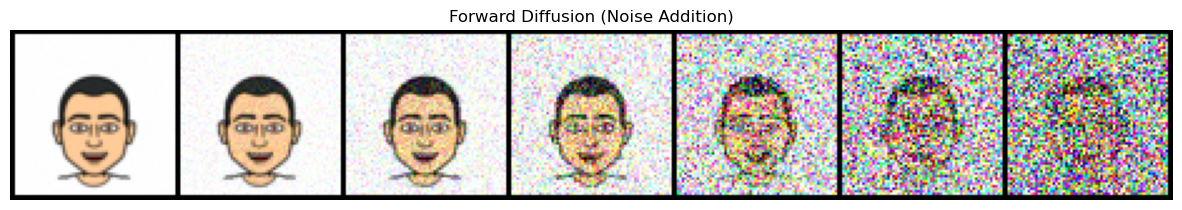

In [9]:
# VISUALIZE NOISE ADDITION
# -------------------------------
def show_forward_process(img):
    img = img.unsqueeze(0).to(device)
    t_values = [0, 10, 25, 50, 100, 150, 199]

    noisy_imgs = []
    for t in t_values:
        x_t, _ = q_sample(img, torch.tensor([t],device=device))
        noisy_imgs.append((x_t[0].cpu()+1)/2)

    grid = make_grid(noisy_imgs, nrow=len(t_values))
    plt.figure(figsize=(15,4))
    plt.imshow(grid.permute(1,2,0))
    plt.axis("off")
    plt.title("Forward Diffusion (Noise Addition)")
    plt.show()

example_img = next(iter(loader))[0]
show_forward_process(example_img)

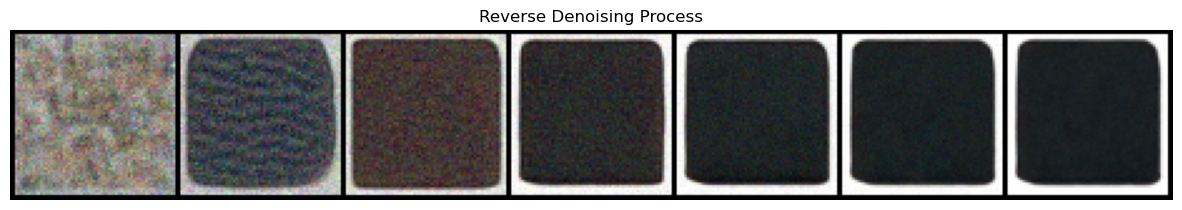

In [10]:
# REVERSE SAMPLING
# -------------------------------
def p_sample(model, x, t):
    noise_pred = model(x, torch.tensor([t], device=device).repeat(x.size(0)))
    ac = alphas[t]
    bc = betas[t]
    om = sqrt_om[t]

    x0_pred = (x - om*noise_pred) / torch.sqrt(ac)

    if t == 0:
        return x0_pred

    noise = torch.randn_like(x)
    return x0_pred + torch.sqrt(bc) * noise

def sample(model):
    model.eval()
    x = torch.randn(1,3,64,64).to(device)

    reverse_imgs = []

    for t in reversed(range(T_STEPS)):
        x = p_sample(model,x,t)
        if t in [199,150,100,50,25,10,0]:
            reverse_imgs.append((x[0].cpu()+1)/2)

    return reverse_imgs

reverse_imgs = sample(model)

plt.figure(figsize=(15,4))
plt.imshow(make_grid(reverse_imgs,nrow=len(reverse_imgs)).permute(1,2,0))
plt.axis("off")
plt.title("Reverse Denoising Process")
plt.show()

In [11]:
# -------------------------------
# Evaluation: Noise Prediction MSE
# -------------------------------
def evaluate_noise_mse(model, loader, num_batches=5):
    model.eval()
    total_mse = 0
    count = 0

    with torch.no_grad():
        for batch in loader:
            x0 = batch.to(device)
            b = x0.size(0)
            t = torch.randint(0, T_STEPS, (b,), device=device)

            xt, noise = q_sample(x0, t)
            noise_pred = model(xt, t)

            mse = F.mse_loss(noise_pred, noise, reduction='mean')
            total_mse += mse.item()
            count += 1

            if count >= num_batches:
                break

    return total_mse / count

final_noise_mse = evaluate_noise_mse(model, loader)
print(f"\n==== Evaluation ====\nNoise Prediction MSE: {final_noise_mse:.6f}\n")


==== Evaluation ====
Noise Prediction MSE: 0.037440



Reconstruction MSE: 0.829785


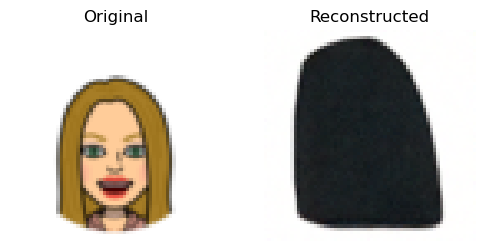

In [12]:
# -------------------------------
# Evaluate Reconstruction Ability
# -------------------------------
def reconstruct(model, img):
    img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        x = img.clone()
        for t in reversed(range(T_STEPS)):
            x = p_sample(model, x, t)

    return x[0].cpu()

def reconstruction_mse(model, loader):
    model.eval()
    batch = next(iter(loader))
    x0 = batch[0]  # take first image
    x_hat = reconstruct(model, x0)

    mse = torch.mean((x_hat - x0.cpu())**2).item()
    return mse, x0, x_hat

rec_mse, original_img, reconstructed_img = reconstruction_mse(model, loader)

print(f"Reconstruction MSE: {rec_mse:.6f}")

# Show comparison
plt.figure(figsize=(6,3))

plt.subplot(1,2,1)
plt.title("Original")
plt.imshow(((original_img + 1) / 2).permute(1, 2, 0))
plt.axis('off')

plt.subplot(1,2,2)
plt.title("Reconstructed")
plt.imshow(((reconstructed_img + 1) / 2).permute(1, 2, 0))
plt.axis('off')

plt.show()